# Predicción de emociones faciales en tiempo real

## Importando las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import os

Confirmamos la versión de Tensorflow ya que el entrenamiento de la red neuronal se realizó en Google Colab y se utilizó la versión 2.5.0

In [145]:
print(tf.__version__)

2.5.0


A continuación se puede ver una muestra de los datos que se van a utilizar (en este caso trabajaremos con un dataset de imagenes de 48x48 pixeles en color (es por esto que tienen 3 capas "RGB")

(48, 48, 3)


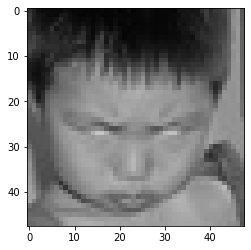

In [146]:
x = cv2.imread("./train/angry/Training_10118481.jpg")
plt.imshow(x)
print(x.shape)

Asignamos una variable para el directorio y otra para las clases, de esta manera nos será más facil referirnos a las distintas emociones

In [151]:
Datadirectory = "./train/"
Classes = ["angry","disgust","fear","happy","neutral","sad","surprise"]

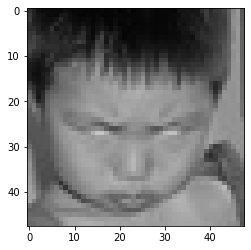

In [152]:
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

La red neuronal que vamos a utilizar necesita que las imagenes sean mínimo de 224x224 pixeles, con lo cual hacemos la conversión la imagen (pasamos de 48x48 a 224x224)

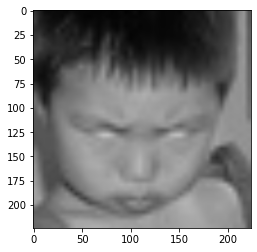

In [5]:
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
new_array.shape

(224, 224, 3)

## Creando el conjunto de entrenamiento y testing de las imagenes

Primero reescalamos todas las imagenes para que los valores de los pixeles estén de 0 hasta 1 y luego creamos un conjunto de entrenamiendo y testing creando más imagenes con la función de preprocesing que incluye keras

En dicha función lo que estamos haciendo es girando horizontalmente las imagenes y aumentando el zoom de las imagenes, de este modo la red neuronal tendrá un mayor numero de imagenes para entrenar

In [155]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=30, width_shift_range=0.3,
                                                          height_shift_range=0.3, fill_mode="nearest")
testdatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train = datagen.flow_from_directory("./train", 
                                    target_size=(img_size,img_size),
                                    class_mode = "sparse",
                                    seed=1,shuffle=True, batch_size = 32)
test = testdatagen.flow_from_directory("./test", 
                                    target_size=(img_size,img_size),
                                    class_mode = "sparse",
                                    seed=1,shuffle=True, batch_size = 32)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [156]:
x, y = train.next()
print(x.shape, y.shape)
train.reset()

(32, 224, 224, 3) (32,)


In [157]:
len(train)

898

In [12]:
test.image_shape

(224, 224, 3)

## Importando las librerías para entrenar la red neuronal

In [158]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
from tensorflow.keras.models import load_model

Trabajaremos con una red neuronal ya entrenada y cambiaremos las ultimas capas para que se adapte a las imagenes que estamos queriendo predecir, de este modo estamos utilizando la transferencia de conocimientos de uan red ya pre entrenada y le será mas facil llegar a un alto porcentaje de precisión.

In [159]:
model = tf.keras.applications.MobileNetV2()

In [160]:
base_input = model.layers[0].input

In [161]:
base_output = model.layers[-2].output

In [162]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation("relu")(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation("relu")(final_output)
final_output = layers.Dense(7, activation="softmax")(final_output)

In [163]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

Hemos modificado las ultimas capas de la red neuronal y en la capa de salida le hemos aladido 7 neuronas corresponeidntes a cada una de las emociones que queremos predecir.

In [164]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Podemos ver un sumario de las distintas capas de la red neuronal

In [165]:
new_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

En este caso entrenaremos la red neuronal por 25 epocas solamente con el conjunto de entrenamiento ya que el testing lo realizaremos con imagenes sacadas de internet y con vídeo en tiempo real. (Por el tiempo que tarda dicha red neuronal entrenando esto lo hicimos en Google Colab utilizando una GPU) Guardamos y descargamos el modelo entrenado en el ordenador

In [ ]:
new_model.fit(train, validation_data=test, validation_steps=len(train),epochs=25,steps_per_epoch=len(train), shuffle=True)
new_model.save("Emotion_detection2.h5")
files.download("Emotion_detection2.h5")

Como el paso de entrenamiento lo hemos realizado fuera de Jupiter Notebook a continuación cargaremos el modelo desde un archivo en el orednador y lo probaremos con unas imagenes descargadas de internet

In [131]:
new_model = load_model("./Emotion_detection.h5")

In [132]:
frame = cv2.imread("./Angry.jfif")

In [133]:
frame.shape

(183, 275, 3)

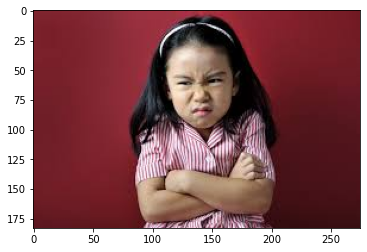

In [134]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [135]:
facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [136]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
backtorgb=cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [137]:
gray.shape

(183, 275)

In [138]:
faces = facecascade.detectMultiScale(gray, 1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)
    facess = facecascade.detectMultiScale(roi_gray)
    if len(facess)==0:
        print("Face not detected")
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

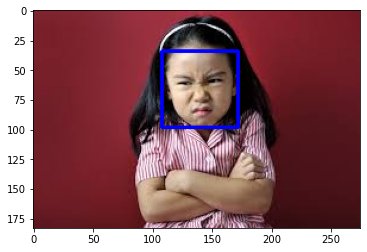

In [139]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

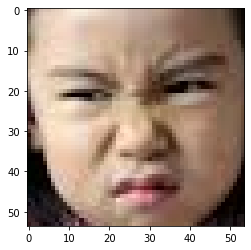

In [140]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [141]:
final_image = cv2.resize(face_roi, (224,224))
final_image = np.expand_dims(final_image,axis=0)
final_image = final_image/255.0

Hemos aplicado el algoritmo de facecascade que se puede encontrar en el repositorio de "opencv". esto nos permite detectar la cara de una foto cualquiera y recortarla para posteriormente analizarla con nuestro algoritmo entrenado.

In [142]:
Predictions = new_model.predict(final_image)

In [166]:
Clases = ["Enfado","Asco","Miedo","Felicidad","Neutral","Tristeza","Sorpresa"]

Creamos una variable nueva de las distintas clases en español para que la predicción no sea un numero si no que dicho número se corresponda a una emoción, de esta manera será mucho más facil de interpretar.

In [168]:
print (Clases[np.argmax(Predictions)])

Felicidad


## Importamos nuevamente las librerías para la prueba con imagenes de la camara web

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
import joblib
from tensorflow.keras.models import load_model

Importamos nuevamente el modelo por si reiniciamos el kernel de Jupiter

In [127]:
new_model = load_model("./Emotion_detection2.h5")

## Probando la red neuronal con imagenes de la camara web

Aquí lo que haremos será encender la camara web del ordenador con la función de "cv2.Videocapture" y le estaremos diciendo que analice los fotogramas de la camara y sobre esto que aplique el algoritmo para predecir la emoción.
(Los pasos que estan previos a la función de encender la camara son simplemente esteticos y son para determianar como queremos que nos muestre la predicción)

In [144]:
import cv2
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangular_bgr = (255,255,255)
img = np.zeros((500,500))
text = "Some text in a box!"
(text_width, text_height) = cv2.getTextSize(text,font, fontScale = font_scale, thickness = 1)[0]

text_offset_x = 10
text_offset_y = img.shape[0]-25

box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangular_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0,0,0), thickness = 1)

cap = cv2.VideoCapture(0)

while True:
    ret,frame = cap.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(faces)==0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex + ew]
                
    final_image = cv2.resize(face_roi, (224,224))
    final_image = np.expand_dims(final_image,axis=0)
    final_image = final_image/255.0

    font = cv2.FONT_HERSHEY_SIMPLEX

    Predictions=new_model.predict(final_image)

    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    status = Classes[np.argmax(Predictions)]

    x1, y1, w1, h1 = 0,0,175,75
    cv2.rectangle(frame, (x1,x1),(x1+w1, y1+h1), (0,0,0), -1)
    cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    cv2.putText(frame, status, (100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))


    cv2.imshow("Face Emotion Recognition", frame)

    if cv2.waitKey(2) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()